In [1]:
folder_path = f"/home/jhongfongfah/PYTORCH_PROJ/[Hong] week04"

# Image Classification by DNN

The goal of image classification is to classify an image $x$ into one of $K$ classes. DNN implements this as a non-linear function that maps $x$ to a $K$-dim vector $y$ representing the probability of being each class. Once $y$ is obtained, the class (i.e., row) of the largest value in $y$ is considered as the predicted class of $x$. To train such DNNs, we provide a training dataset, a collection of an image $x$ and its ground truth class label $t$ pairs.

* Input: an image $x$ ($64{\times}64$ grayscale in this exercise).
* Output: a $K$-dim vector $y$ representing the probability of being each class.
* Supervision: the ground truth class $t \in \mathbb{Z} (0 \le t < K)$ of $x$.

We use PyTorch to implement DNN in this exercise.  PyTorch follows "define by run" programming model, and its scripts mainly consist of the following three parts:

1. Data (`torch.utils.data.Dataset` and `torch.utils.data.DataLoader`),
2. Network (`torch.nn.Sequential`, `torch.nn.Module`), and
3. Training (`torch.optim.SGD`).


### References
* [Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition](https://cs231n.github.io/)
* "Deep Learning" by I. Goodfellow et al. ([online version](https://www.deeplearningbook.org/))

# 0. Data

The following cell loads an NPZ file that includes images and labels.
* `IMG`: numpy array of 64x64 grayscale images. Each image contains one handwritten Japanese character.  (source [ETL Character Database](http://etlcdb.db.aist.go.jp))
* `MOJI`: numpy array of Python string corresponding to the character of the images.
* `LABEL`: numpy array of integers representing the class ID $[0:955]$. The first $[0:74]$ IDs are hiragana.
* `HIRA`: numpy arrary of integers. $1$ if the image is hiragana and $0$ otherwise.


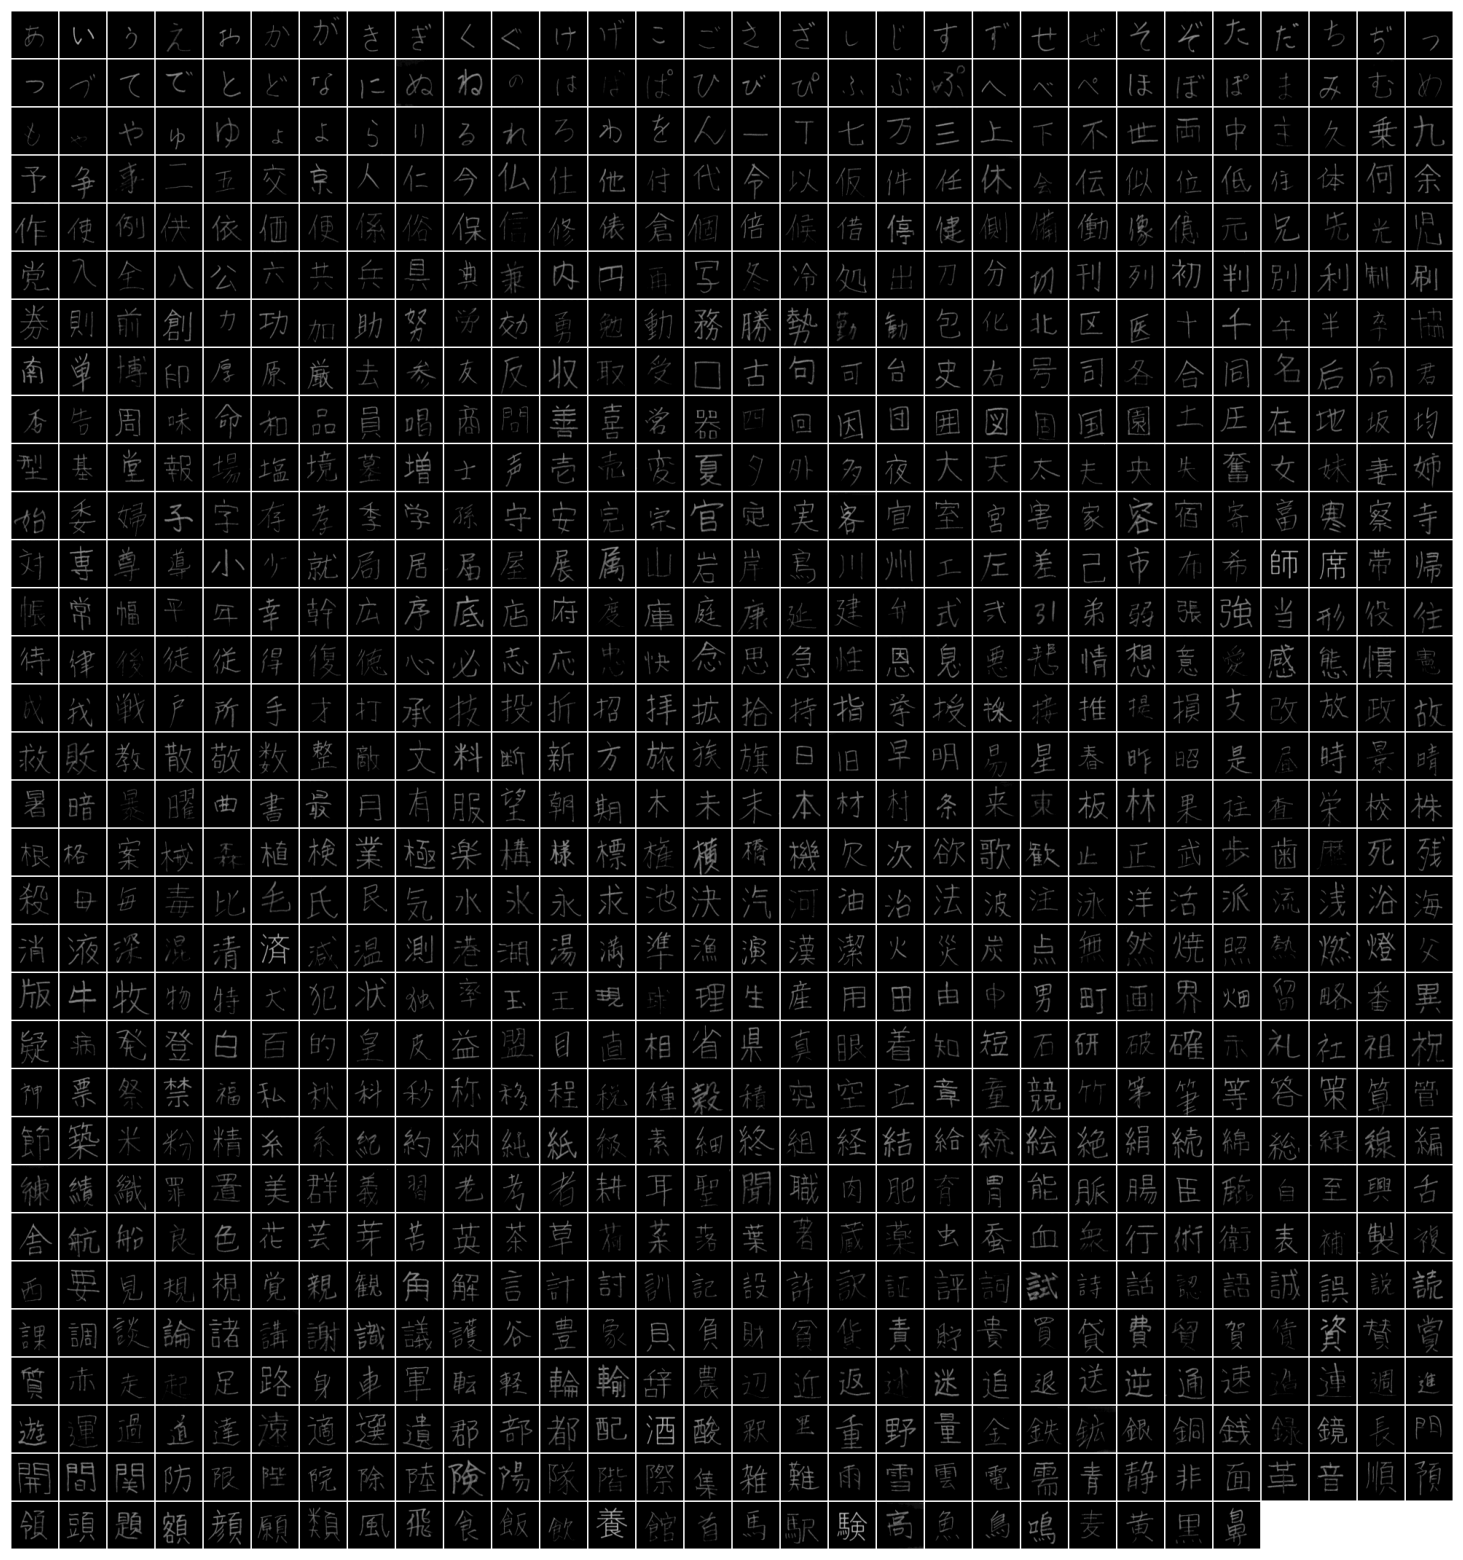

In [2]:
import numpy as np
import torch
from torch import nn
import torchvision
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import PIL
from PIL import Image

SKIP=10
assert 160 % SKIP == 0

DATA = np.load(f'{folder_path}/Practice_DNN/ETL8G_64x64.npz')

# 64x64 images, 956 characters, 160 images per class
IMG = DATA['img']

# the label [0:955] of each image.  [0:74] == hiragana, [75:] == kanji
LABEL = DATA['label'].astype(np.int64)

# the character of each image
MOJI = DATA['moji']

# if the character is a hiragana or not
HIRA = DATA['hira'].astype(np.int64)

if SKIP > 1:
    IMG = IMG[::SKIP,:,:]
    LABEL = LABEL[::SKIP]
    MOJI = MOJI[::SKIP]
    HIRA = HIRA[::SKIP]

# show thumbnails
plt.figure(figsize=(20.0, 20.0))
grid = torchvision.utils.make_grid(torch.from_numpy(IMG[::160//SKIP,None,:,:].astype(float) / 255), nrow=30, pad_value=1)
plt.imshow(grid.clamp(0, 1).permute(1, 2, 0).expand(-1, -1, 3).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()


# 1. Dataset and DataLoader

In PyTorch, we need to define a dataset which provides access to the data and label and a dataloader which (randomly) samples data/label pairs from a dataset.

* Dataset: implements `__getitem__()` and `__len__()` functions to abstract the actual representation of the training data.  The real data can be a collection of individual image files (`torchvision.datasets.ImageFolder`), databases (such as LMDB, SQLITE, or even some database servers on different host), or something else which implements the two interface functions anyway.
* DataLoader: implements a random sampler of the dataset.  In most cases, we can simply use `torch.utils.data.DataLoader`.

In the next cell, we implement our own dataset which wraps NumPy array.

In [3]:
# Split
from sklearn.model_selection import train_test_split
I_train, I_test, L_train, L_test, M_train, M_test, H_train, H_test = train_test_split(IMG, LABEL, MOJI, HIRA)
print('IMG  : ', I_train.shape, I_test.shape)
print('LABEL: ', L_train.shape, L_test.shape)
print('MOJI : ', M_train.shape, M_test.shape)
print('HIRA : ', H_train.shape, H_test.shape)



class CustomTensorDataset(torch.utils.data.Dataset):
    """
    TensorDataset with support of transforms.
    https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset
    """
    def __init__(self, tensors, transform=None):
        self.tensors = tensors
        self.transform = transform

    def __getitem__(self, index):
        x = self.tensors[0][index, :, :]
        if self.transform:
            x = self.transform(PIL.Image.fromarray(x))

        y = self.tensors[1][index]

        return x, y

    def __len__(self):
        return self.tensors[0].shape[0]


transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    # transforms.Normalize(mean=[0, 0, 0], std=[255.0, 255.0, 255.0]),  # [0:255] -> [0:1]
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# data loader
def get_dataloader(dataset, batch_size=128, shuffle=True, device=None):
    uses_cuda = False if device is None else device.type == 'cuda'
    return torch.utils.data.DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=shuffle,
            #num_workers=4 if uses_cuda else 0,
            pin_memory=uses_cuda  # True if CUDA
            )

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

train_loader = get_dataloader(CustomTensorDataset((I_train, H_train), transform), device=device)
test_loader = get_dataloader(CustomTensorDataset((I_test, H_test), transform), device=device)


IMG  :  (11472, 64, 64) (3824, 64, 64)
LABEL:  (11472,) (3824,)
MOJI :  (11472,) (3824,)
HIRA :  (11472,) (3824,)
cuda


In [4]:
for inputs, hira in train_loader:
    print(f'Inputs dtype: {inputs.dtype}, Hira dtype: {hira.dtype}')
    break  # Print once for checking

Inputs dtype: torch.float32, Hira dtype: torch.int64


# 2. Network

To define a neural network, we define our own class which inherits `torch.nn.Module`.  A typical implementation includes
* the constructor `__init__()` that instanciates all network modules, and
* the inference function `forward()` that computes the output given an input `x`.

The key points here are:
1. The member variables such as `self.block1` are automatically recognized by PyTorch as training targets.  Such automatic recognition is applied only to variables of types in `torch.nn`.
   * Caution: use of lists of modules (for example a list of `nn.Conv2d`) will not be recognized by the optimizer automatically.
2. The input `x` of `__forward__()` is in so-called NCHW format. Here $N$ is the number of training samples (i.e., number of images) in a minibatch. In Tensorflow it will be in NHWC. Be aware of the difference.

In [5]:
class HiraganaModel(nn.Module):
    def __init__(self):
        super(HiraganaModel, self).__init__()
        # we can reuse staleless modules safely. https://discuss.pytorch.org/t/reusing-nn-dropout-relu-maxpool-in-forward/75409/4
        self.act = nn.LeakyReLU(0.2)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.drop = nn.Dropout(p=0.5)

        self.block1 = nn.Sequential(
            nn.Conv2d(  1,  64, 3, 1, 1), nn.BatchNorm2d( 64), self.act,
            nn.Conv2d( 64,  64, 3, 1, 1), nn.BatchNorm2d( 64), self.act,
            self.pool,
            nn.Conv2d( 64, 128, 3, 1, 1), nn.BatchNorm2d(128), self.act,
            nn.Conv2d(128, 128, 3, 1, 1), nn.BatchNorm2d(128), self.act,
            self.pool,
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), self.act,
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), self.act,
            self.pool,
            )

        self.block2 = nn.Sequential(
            nn.Linear(8*8*256, 4096), self.act, self.drop,
            nn.Linear(4096, 4096), self.act, self.drop,
            nn.Linear(4096, 2),
            )


    def forward(self, x):
        x = self.block1(x)
        x = x.view(x.size(0), -1)
        x = self.block2(x)
        return x

model = HiraganaModel().to(device)
print(model)
print(device)


HiraganaModel(
  (act): LeakyReLU(negative_slope=0.2)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout(p=0.5, inplace=False)
  (block1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128

# 3. Training

The last step is to define a training loop.  PyTorch provides some standard optimizers such as `Adagrad` and loss functions such as `CrossEntropyLoss`.

A typical loop will look as follows.
1. iterate the following for $N_\mathrm{epoch}$ times
   1. for each minibatch from the dataloader,
      1. transfer the data to the device (GPU or CPU)
      2. compute the output by `forward()`.
      3. compute the loss
      4. compute the gradient
      5. update the model parameters
      6. (show the current loss / accuracy)
    2. show the current loss / accuracy with the test data
    3. save the current parameters if needed
2. save the final parameters.


In [7]:
OUTNAME = f'{folder_path}/Practice_DNN/DNN_01_output'
N_epoch = 10

optimizer = torch.optim.Adagrad(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

train_losses = []
test_losses = []
test_accuracies = []
for epoch in range(1, 1+N_epoch):
    # Switch to training mode
    model.train()
    # Per-minibatch training
    loss_sum = 0
    input_count = 0
    bar = tqdm(train_loader, desc='Train Epoch: %d' % epoch, unit='batches')
    for inputs, labels in bar:
        input_count += len(inputs)
        # transfer to the device
        inputs, labels = inputs.to(device), labels.to(device)
        # forward
        outputs = model(inputs)
        # loss computation
        loss = criterion(outputs, labels)
        # initialize the gradient
        optimizer.zero_grad()
        # update the gradient
        loss.backward()
        # update the parameters
        optimizer.step()
        # show losses
        loss_sum += loss.item() * len(inputs)
        bar.set_postfix(loss_avg=loss_sum / input_count)
    train_losses.append(loss_sum/input_count)
    # Switch to inference mode
    model.eval()
    loss_sum = 0
    correct_sum = 0
    input_count = 0
    with torch.no_grad(): # We do not need autograd for inference
        bar = tqdm(test_loader, desc='Test', unit='batches')
        for inputs, labels in bar:
            input_count += len(inputs)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss_sum += criterion(outputs, labels).item() * len(inputs)
            pred = outputs.argmax(dim=1, keepdim=True)
            correct_sum += pred.eq(labels.view_as(pred)).sum().item()
            bar.set_postfix(loss_avg=loss_sum / input_count, accuracy=correct_sum / input_count)
    test_loss, test_accuracy = loss_sum / input_count, 100 * correct_sum / input_count

    # save the model if it is better than before
    if len(test_losses) > 1 and test_loss < min(test_losses):
        torch.save(model.state_dict(), f'{OUTNAME}_best_loss.tar')

    if len(test_accuracies) > 1 and test_accuracy > max(test_accuracies):
        torch.save(model.state_dict(), f'{OUTNAME}_best_accuracy.tar')

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

torch.save(model.state_dict(), f'{OUTNAME}.tar')

Train Epoch: 1:   0%|          | 0/90 [00:00<?, ?batches/s]

Test:   0%|          | 0/30 [00:00<?, ?batches/s]

Train Epoch: 2:   0%|          | 0/90 [00:00<?, ?batches/s]

Test:   0%|          | 0/30 [00:00<?, ?batches/s]

Train Epoch: 3:   0%|          | 0/90 [00:00<?, ?batches/s]

Test:   0%|          | 0/30 [00:00<?, ?batches/s]

Train Epoch: 4:   0%|          | 0/90 [00:00<?, ?batches/s]

Test:   0%|          | 0/30 [00:00<?, ?batches/s]

Train Epoch: 5:   0%|          | 0/90 [00:00<?, ?batches/s]

Test:   0%|          | 0/30 [00:00<?, ?batches/s]

Train Epoch: 6:   0%|          | 0/90 [00:00<?, ?batches/s]

Test:   0%|          | 0/30 [00:00<?, ?batches/s]

Train Epoch: 7:   0%|          | 0/90 [00:00<?, ?batches/s]

Test:   0%|          | 0/30 [00:00<?, ?batches/s]

Train Epoch: 8:   0%|          | 0/90 [00:00<?, ?batches/s]

Test:   0%|          | 0/30 [00:00<?, ?batches/s]

Train Epoch: 9:   0%|          | 0/90 [00:00<?, ?batches/s]

Test:   0%|          | 0/30 [00:00<?, ?batches/s]

Train Epoch: 10:   0%|          | 0/90 [00:00<?, ?batches/s]

Test:   0%|          | 0/30 [00:00<?, ?batches/s]

# Exercise

Train a network that estimates the label (available as `LABEL`) of $x$.  This can be done by implementing
1. a new dataset,
2. a new dataloader, and
2. a new network.


You can first try a "hiragana-only" case for simplicity.  That is, you can define a subset of $x$ which includes hiragana only, and then predict its hiragana label.
